# Import Library

In [124]:

import time
import glob
import datetime
import random
import pickle
import numpy as np
import shutil
import os
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1) # (A)
import keras.optimizers  # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from decimal import *
from keras.layers.recurrent import SimpleRNN, LSTM
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score

# Load DF

In [48]:
class DataFramePreProcessing():

    
    def __init__(self, path_):
        self.path_ = path_

        
    def load_df(self):
        FILE = glob.glob(path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                       df.columns[9]:'nan',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

# Make Train Data

In [171]:

class MakeTrainData2class():
    
    
    def __init__(self, df, stride, test_rate, column='close', scale_type='standard', is_category=True):
        self.df = df
        self.stride = stride # Assume stride>=1
        self.test_rate = test_rate
        self.column = column
        self.scale_type = scale_type
        self.is_category= is_category
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
        
    def make_data(self):
        x = []
        y = []
        up, down = self.labeling()
        df_column = self.df[self.column]
        for i in range(len(df_column)-self.stride):
            price_list = df_column.iloc[i:i+self.stride].tolist()
            today_price = df_column.iloc[i+self.stride-1]
            tommorow_price = df_column.iloc[i+self.stride]
            
            
            if tommorow_price > today_price:# if up
                y.append(up)
            else: # if down or equal, but equal price is rare case.
                y.append(down)
                
            
            if self.scale_type == 'standard':
                x.append(preprocessing.scale(np.array(price_list)).reshape(-1).tolist())
            elif self.scale_type == 'robust':
                x.append(preprocessing.robust_scale(np.array(price_list)).reshape(-1).tolist())
            elif self.scale_type == 'minmax':
                x.append(preprocessing.minmax_scale(np.array(price_list)).reshape(-1).tolist())
                
                
        TEST_RATE = len(x)*self.test_rate
        TEST_RATE = int(TEST_RATE)
        x,y              = np.array(x),np.array(y)
        x_train,y_train  = x[:TEST_RATE],y[:TEST_RATE]
        x_test,y_test    = x[TEST_RATE:], y[TEST_RATE:]
        
        train_up_count   = y_train[y_train==up].shape[0]
        train_down_count = y_train[y_train==down].shape[0]
        test_up_count    = y_test[y_test==up].shape[0]
        test_down_count  = y_test[y_test==down].shape[0]
        print("Train UP :",train_up_count,"DOWN :",train_down_count) # if is_one_hot, count is twice times as large as true count.
        print("Test  UP :",test_up_count,"DOWN :",test_down_count)
        return x_train, y_train, x_test, y_test
    
    
    def under_sampling(self):
        x_train, y_train, x_test, y_test = self.make_data()
        if not self.is_category:
            y_train =  np.argmax(y_train, axis=1)
            y_test  =  np.argmax(y_resampled, axis=1)        
        
        
        x_resampled_train, y_resampled_train = self.lose_label(x_train, y_train)
        x_resampled_test, y_resampled_test = self.lose_label(x_test, y_test)
        train_up_count   = y_resampled_train[y_resampled_train==1].shape[0]
        train_down_count = y_resampled_train[y_resampled_train==0].shape[0]
        test_up_count    = y_resampled_test[y_resampled_test==1].shape[0]
        test_down_count  = y_resampled_test[y_resampled_test==0].shape[0]
        print("Train UP :",train_up_count,"DOWN :",train_down_count) # if is_one_hot, count is twice times as large as true count.
        print("Test  UP :",test_up_count,"DOWN :",test_down_count)
        
        
        if not self.is_category:
            y_resampled_train = np.identity(2)[y_resampled_train]
            y_resampled_test = np.identity(2)[y_resampled_test]

        
        return x_resampled_train, y_resampled_train, x_resampled_test, y_resampled_test
        
    def lose_label(self, x, y):
        rus = RandomUnderSampler(random_state=0)
        x_resampled, y_resampled = rus.fit_resample(x, y)
        
        return x_resampled, y_resampled
    
    
    


In [166]:
y_resampled

array([0, 0, 0, ..., 1, 1, 1])

In [143]:
path2 = '/Users/rince/Desktop/StockPriceData/Stock_index/NFNK225_10years.csv'

df_nf225 = DataFramePreProcessing.load_df(path2)

x_train, y_train, x_test, y_test = MakeTrainData2class( df_nf225, stride=5, test_rate=0.8).make_data()
# Train UP : 2170 DOWN : 1902
# Test UP : 560 DOWN : 458

# Train UP : 1085 DOWN : 951
# Test UP : 280 DOWN : 229

Train UP : 1085 DOWN : 951
Test  UP : 280 DOWN : 229


# Search best stride

In [170]:
for i in [2,4,8,16]:
    for scale_type in ['standard','robust','minmax']:
        print("i :",i,"scale_type :",scale_type)
        x_train, y_train, x_test, y_test = MakeTrainData2class( df_nf225, stride=i, test_rate=0.8, scale_type=scale_type).under_sampling()
        xgb_model = xgb.XGBClassifier(use_label_encoder=False)
        hr_pred = xgb_model.fit(x_train, y_train).predict(x_test)
        print(classification_report(y_test, hr_pred))
        print("----------------------------------------")

i : 2 scale_type : standard
Train UP : 1084 DOWN : 954
Test  UP : 281 DOWN : 229
Train UP : 954 DOWN : 954
Test  UP : 229 DOWN : 229
[22:52:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       229
           1       0.55      0.46      0.50       229

    accuracy                           0.54       458
   macro avg       0.54      0.54      0.54       458
weighted avg       0.54      0.54      0.54       458

----------------------------------------
i : 2 scale_type : robust


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1084 DOWN : 954
Test  UP : 281 DOWN : 229
Train UP : 954 DOWN : 954
Test  UP : 229 DOWN : 229
[22:52:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       229
           1       0.55      0.46      0.50       229

    accuracy                           0.54       458
   macro avg       0.54      0.54      0.54       458
weighted avg       0.54      0.54      0.54       458

----------------------------------------
i : 2 scale_type : minmax


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1084 DOWN : 954
Test  UP : 281 DOWN : 229
Train UP : 954 DOWN : 954
Test  UP : 229 DOWN : 229
[22:52:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       229
           1       0.55      0.46      0.50       229

    accuracy                           0.54       458
   macro avg       0.54      0.54      0.54       458
weighted avg       0.54      0.54      0.54       458

----------------------------------------
i : 4 scale_type : standard


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1084 DOWN : 952
Test  UP : 281 DOWN : 229
Train UP : 952 DOWN : 952
Test  UP : 229 DOWN : 229
[22:52:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       229
           1       0.50      0.49      0.50       229

    accuracy                           0.50       458
   macro avg       0.50      0.50      0.50       458
weighted avg       0.50      0.50      0.50       458

----------------------------------------
i : 4 scale_type : robust


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1084 DOWN : 952
Test  UP : 281 DOWN : 229
Train UP : 952 DOWN : 952
Test  UP : 229 DOWN : 229
[22:52:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       229
           1       0.50      0.51      0.50       229

    accuracy                           0.50       458
   macro avg       0.50      0.50      0.50       458
weighted avg       0.50      0.50      0.50       458

----------------------------------------
i : 4 scale_type : minmax


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1084 DOWN : 952
Test  UP : 281 DOWN : 229
Train UP : 952 DOWN : 952
Test  UP : 229 DOWN : 229
[22:52:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       229
           1       0.49      0.51      0.50       229

    accuracy                           0.49       458
   macro avg       0.49      0.49      0.49       458
weighted avg       0.49      0.49      0.49       458

----------------------------------------
i : 8 scale_type : standard


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1083 DOWN : 950
Test  UP : 280 DOWN : 229
Train UP : 950 DOWN : 950
Test  UP : 229 DOWN : 229
[22:52:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.51      0.48      0.49       229
           1       0.51      0.54      0.52       229

    accuracy                           0.51       458
   macro avg       0.51      0.51      0.51       458
weighted avg       0.51      0.51      0.51       458

----------------------------------------
i : 8 scale_type : robust
Train UP : 1083 DOWN : 950
Test  UP : 280 DOWN : 229
Train UP : 950 DOWN : 950
Test  UP : 229 DOWN : 229
[22:52:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       229
           1       0.52      0.58      0.55       229

    accuracy                           0.52       458
 

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train UP : 1083 DOWN : 950
Test  UP : 280 DOWN : 229
Train UP : 950 DOWN : 950
Test  UP : 229 DOWN : 229
[22:52:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.47      0.52      0.49       229
           1       0.47      0.43      0.45       229

    accuracy                           0.47       458
   macro avg       0.47      0.47      0.47       458
weighted avg       0.47      0.47      0.47       458

----------------------------------------
i : 16 scale_type : standard
Train UP : 1082 DOWN : 945
Test  UP : 279 DOWN : 228
Train UP : 945 DOWN : 945
Test  UP : 228 DOWN : 228
[22:52:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.44      0.45      0.44       228
           1       0.44      0.43      0.43       228

    accuracy                           0.44       456
   macro avg       0.44      0.44      0.44       456
weighted avg       0.44      0.44      0.44       456

----------------------------------------
i : 16 scale_type : robust
Train UP : 1082 DOWN : 945
Test  UP : 279 DOWN : 228
Train UP : 945 DOWN : 945
Test  UP : 228 DOWN : 228
[22:52:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.49      0.54      0.51       228
           1       0.48      0.43      0.45       228

    accuracy                           0.48       456
   macro avg       0.48      0.48      0.48       456
weighted avg       0.48      0.48      0.48       456

----------------------------------------
i : 16 scale_type : minmax
Train UP : 1082 DOWN : 945
Test  UP : 279 DOWN : 228
Train UP : 945 DOWN : 945
Test  UP : 228 DOWN : 228
[22:52:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.49      0.56      0.52       228
           1       0.49      0.42      0.45       228

    accuracy                           0.49       456
   macro avg       0.49      0.49      0.49       456
weighted avg       0.49      0.49      0.49       456

----------------------------------------


In [139]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
hr_pred = xgb_model.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, hr_pred))

/usr/local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:48:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       229
           1       0.49      0.55      0.52       229

    accuracy                           0.49       458
   macro avg       0.49      0.49      0.49       458
weighted avg       0.49      0.49      0.49       458



In [53]:
path_ = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'

df_daw = DataFramePreProcessing.load_df(path_)
daw_p = df_daw.pct_change()


In [54]:
df_nf225

,open,high,low,close
day,,,,
2011-07-06,12626.02,12626.02,12626.02,12626.02
2011-07-07,12719.49,12719.49,12719.49,12719.49
2011-07-08,12657.20,12657.20,12657.20,12657.20
2011-07-11,12505.76,12505.76,12505.76,12505.76
2011-07-12,12446.88,12446.88,12446.88,12446.88
...,...,...,...,...
2021-06-28,34283.27,34283.27,34283.27,34283.27
2021-06-29,34292.29,34292.29,34292.29,34292.29
2021-06-30,34502.51,34502.51,34502.51,34502.51


In [27]:
print(x_train.shape)
print(y_train.shape)

(1902, 6)
(1902,)


In [28]:
length = len(x_)
test_rate = int(0.8*length)

x_train,y_train = x_[:test_rate],y_[:test_rate]
x_test,y_test = x_[test_rate:],y_[test_rate:]
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_train.shape[1])
y_train = np.argmax(y_train,axis=1)
y_test = np.argmax(y_test,axis=1)

# XGB predict

In [22]:
def xgb_pred(x_train,y_train,x_test,y_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    param = {'eta': 0.09107858292565747, 'max_depth': 6, 'lambda': 0.9335155074430995, 'objective': 'multi:softmax', 'num_class': 3}  

    num_round = 30
    bst = xgb.train(param, dtrain,num_round)  
#     bst = xgb.train(param, dtrain,num_round)  
    # bst = xgb.train(dtrain)

    dtest = xgb.DMatrix(x_test)  
    pred = bst.predict(dtest)  

    score = accuracy_score(y_test, pred)  
    print('score:{0:.4f}'.format(score))  

    #     xgb.plot_importance(bst)  

    dtest = xgb.DMatrix(x_test)  
    predict_classes = bst.predict(dtest)  

    true_classes = y_test
    plt.clf()
    cmx = confusion_matrix(true_classes, predict_classes)
    sns.heatmap(cmx, annot=True, fmt='g', square=True)
    plt.show()
    xgb.plot_importance(bst)  
    plt.show()
    
    return bst

[00:26:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score:0.5126


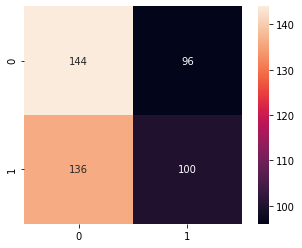

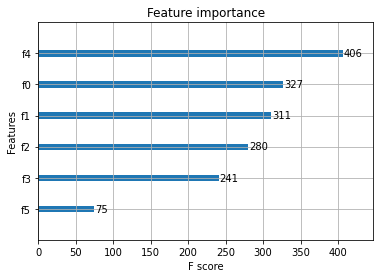

In [29]:
bst = xgb_pred(x_train,y_train,x_test,y_test)